# Minimal SHAP example

In [1]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
# Import machine learning methods
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, \
                            r2_score, root_mean_squared_error

# Import shap for shapley values
import shap

# JavaScript Important for the interactive charts later on
shap.initjs()

In [2]:
knee_proms = pd.read_csv("data/knee_proms_processed.csv")
knee_proms.head()

,provider_code,procedure,revision_flag,year,age_band,gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,...,oks_t0_walking,oks_t0_standing,oks_t0_limping,oks_t0_kneeling,oks_t0_work,oks_t0_confidence,oks_t0_shopping,oks_t0_stairs,oks_t0_score,t1_eq_vas
0,ADP02,Knee Replacement,0,2018/19,NaN,NaN,2,0,2,2,...,2,2,0,1,1,2,2,2,17.0,999
1,ADP02,Knee Replacement,0,2018/19,NaN,NaN,2,0,2,2,...,0,4,1,4,4,3,4,4,37.0,95
2,ADP02,Knee Replacement,0,2018/19,NaN,NaN,2,0,2,2,...,2,4,2,3,3,3,3,4,37.0,98
3,ADP02,Knee Replacement,0,2018/19,NaN,NaN,2,0,2,2,...,2,2,2,0,1,3,3,2,22.0,60
4,ADP02,Knee Replacement,0,2018/19,NaN,NaN,1,0,3,2,...,2,1,0,1,1,0,0,0,12.0,80


In [3]:
knee_proms['gender'].value_counts(dropna=False)

gender
2.0    74085
1.0    55749
NaN     9402
Name: count, dtype: int64

In [4]:
knee_proms['age_band'].value_counts(dropna=False)

age_band
70 to 79     55056
60 to 69     45361
80 to 89     15883
50 to 59     13260
NaN           9402
40 to 49       250
90 to 120       24
Name: count, dtype: int64

In [5]:
knee_proms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139236 entries, 0 to 139235
Data columns (total 46 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   provider_code           139236 non-null  object 
 1   procedure               139236 non-null  object 
 2   revision_flag           139236 non-null  int64  
 3   year                    139236 non-null  object 
 4   age_band                129834 non-null  object 
 5   gender                  129834 non-null  float64
 6   t0_assisted             139236 non-null  int64  
 7   t0_assisted_by          139236 non-null  int64  
 8   t0_symptom_period       139236 non-null  int64  
 9   t0_previous_surgery     139236 non-null  int64  
 10  t0_living_arrangements  139236 non-null  int64  
 11  t0_disability           139236 non-null  int64  
 12  heart_disease           139236 non-null  int64  
 13  high_bp                 139236 non-null  int64  
 14  stroke              

<Axes: >

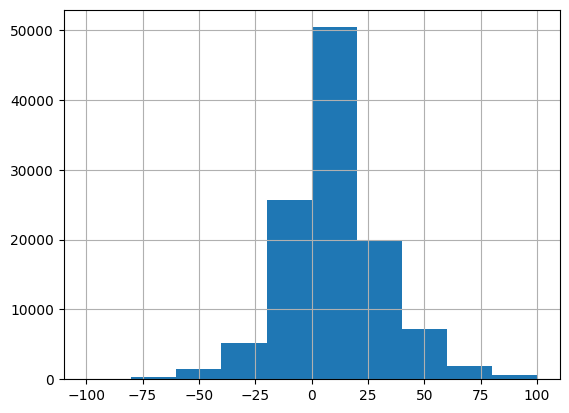

In [6]:
knee_proms = knee_proms.dropna(subset=["age_band", "provider_code"])
knee_proms = knee_proms[knee_proms['t1_eq_vas']<=100]
knee_proms = knee_proms[knee_proms['t0_eq_vas']<=100]
knee_proms['eq_vas_improvement'] = knee_proms['t1_eq_vas'] - knee_proms['t0_eq_vas']

knee_proms['eq_vas_improvement'].hist()

In [8]:
X = knee_proms.drop(columns=['t1_eq_vas', 'procedure', 'year','eq_vas_improvement'])

# t1_eq_vas is the reporting quality of life after operation
y = knee_proms['eq_vas_improvement']

<Axes: >

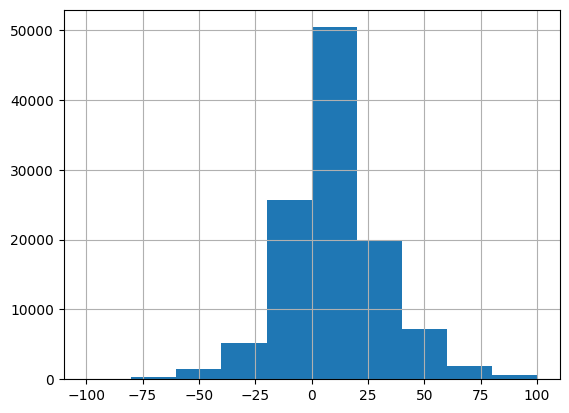

In [9]:
y.hist()

<Axes: >

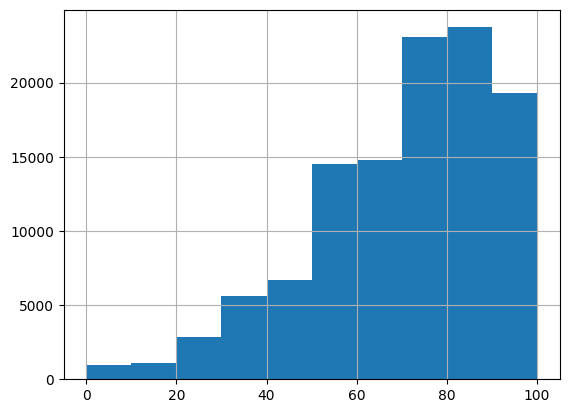

In [10]:
X['t0_eq_vas'].hist()

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112667 entries, 3142 to 139235
Data columns (total 43 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   provider_code           112667 non-null  object 
 1   revision_flag           112667 non-null  int64  
 2   age_band                112667 non-null  object 
 3   gender                  112667 non-null  float64
 4   t0_assisted             112667 non-null  int64  
 5   t0_assisted_by          112667 non-null  int64  
 6   t0_symptom_period       112667 non-null  int64  
 7   t0_previous_surgery     112667 non-null  int64  
 8   t0_living_arrangements  112667 non-null  int64  
 9   t0_disability           112667 non-null  int64  
 10  heart_disease           112667 non-null  int64  
 11  high_bp                 112667 non-null  int64  
 12  stroke                  112667 non-null  int64  
 13  circulation             112667 non-null  int64  
 14  lung_disease          

In [12]:
# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.25,
    random_state=42
    )

model = CatBoostRegressor(random_state=42, cat_features=[0, 2])


In [13]:
# Train the model using the training sets
model.fit(X_train, y_train)

Learning rate set to 0.082532
0:	learn: 21.1451850	total: 215ms	remaining: 3m 34s
1:	learn: 20.5156290	total: 267ms	remaining: 2m 13s
2:	learn: 19.9862444	total: 330ms	remaining: 1m 49s
3:	learn: 19.4954099	total: 391ms	remaining: 1m 37s
4:	learn: 19.0664978	total: 446ms	remaining: 1m 28s
5:	learn: 18.6967301	total: 507ms	remaining: 1m 24s
6:	learn: 18.3585567	total: 566ms	remaining: 1m 20s
7:	learn: 18.0634446	total: 629ms	remaining: 1m 18s
8:	learn: 17.7952675	total: 697ms	remaining: 1m 16s
9:	learn: 17.5732441	total: 760ms	remaining: 1m 15s
10:	learn: 17.3697837	total: 816ms	remaining: 1m 13s
11:	learn: 17.2032331	total: 880ms	remaining: 1m 12s
12:	learn: 17.0457183	total: 935ms	remaining: 1m 11s
13:	learn: 16.9195900	total: 994ms	remaining: 1m 10s
14:	learn: 16.8056426	total: 1.06s	remaining: 1m 9s
15:	learn: 16.7039446	total: 1.12s	remaining: 1m 9s
16:	learn: 16.6169740	total: 1.19s	remaining: 1m 8s
17:	learn: 16.5389490	total: 1.25s	remaining: 1m 8s
18:	learn: 16.4709875	total: 1

In [14]:
# Make predictions using the testing set
y_pred = model.predict(X_test)

print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred):.2f}")

print(f"Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred):.2%}" )

print("Root Mean squared error: %.2f" % root_mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean absolute error: 11.63
Mean absolute percentage error: 384347707324361920.00%
Root Mean squared error: 15.63
Coefficient of determination: 0.48


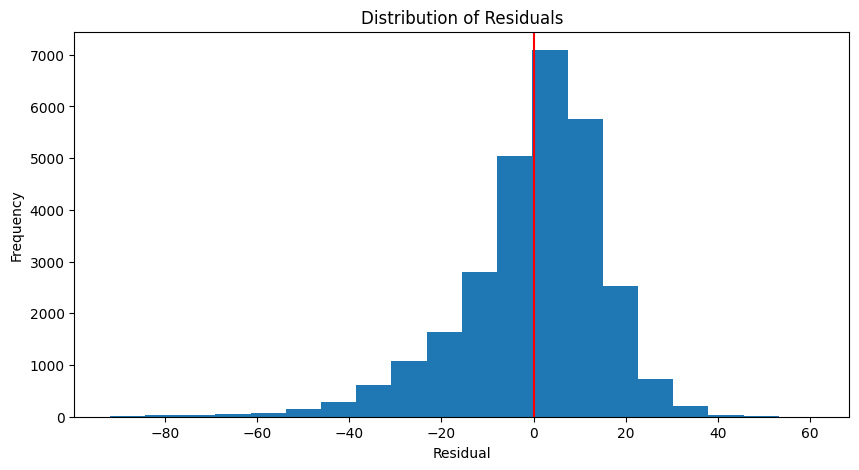

In [23]:
def plot_residuals(actual, predicted):
    residuals = actual - predicted

    plt.figure(figsize=(10, 5))
    plt.hist(residuals, bins=20)
    plt.axvline(x = 0, color = 'r')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.show()

plot_residuals(y_test, y_pred)

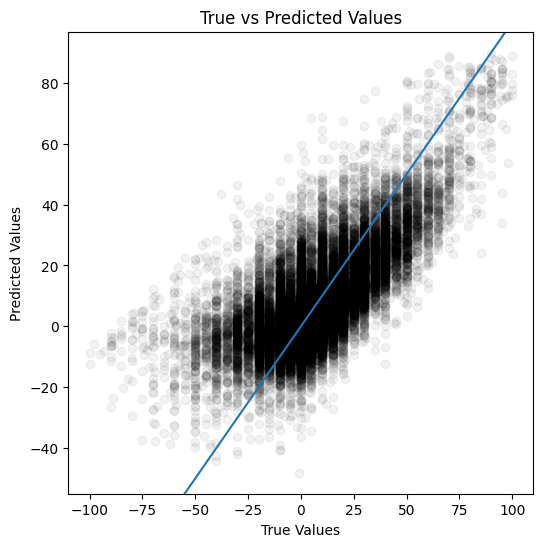

In [24]:
def plot_actual_vs_predicted(actual, predicted):
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.scatter(actual, predicted, color="black", alpha=0.05)
    ax.axline((1, 1), slope=1)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Values')
    plt.show()

plot_actual_vs_predicted(y_test, y_pred)

In [25]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)

shap_values

.values =
array([[-3.68233813e-01,  8.38138299e-02, -1.90396071e+00, ...,
         4.88677124e-01,  8.84405003e-02,  2.86814408e-01],
       [-4.78795484e-01,  1.22558017e-01, -1.47644606e+00, ...,
         4.61516716e-01,  7.49721743e-02, -7.04126354e-02],
       [ 1.09775717e-01,  1.14533258e-01, -1.99894286e+00, ...,
         6.87061622e-01,  1.06192673e-01,  2.13732266e-01],
       ...,
       [-2.06730093e-01,  7.09269540e-02, -5.13246956e-01, ...,
         3.85917869e-01,  1.99219052e-01,  1.16657441e-01],
       [-2.17811199e-01,  8.16824380e-02, -5.29256236e-01, ...,
         2.39661668e-01,  1.69031087e-01,  3.68599043e-02],
       [-2.25337396e-01,  7.35460367e-02, -4.07782527e-01, ...,
         3.55141924e-01,  1.66054966e-01, -5.76684454e-04]])

.base_values =
array([7.50391917, 7.50391917, 7.50391917, ..., 7.50391917, 7.50391917,
       7.50391917])

.data =
array([['ADP02', 0, '50 to 59', ..., 2, 2, 20.0],
       ['ADP02', 0, '50 to 59', ..., 2, 2, 14.0],
       ['ADP02',

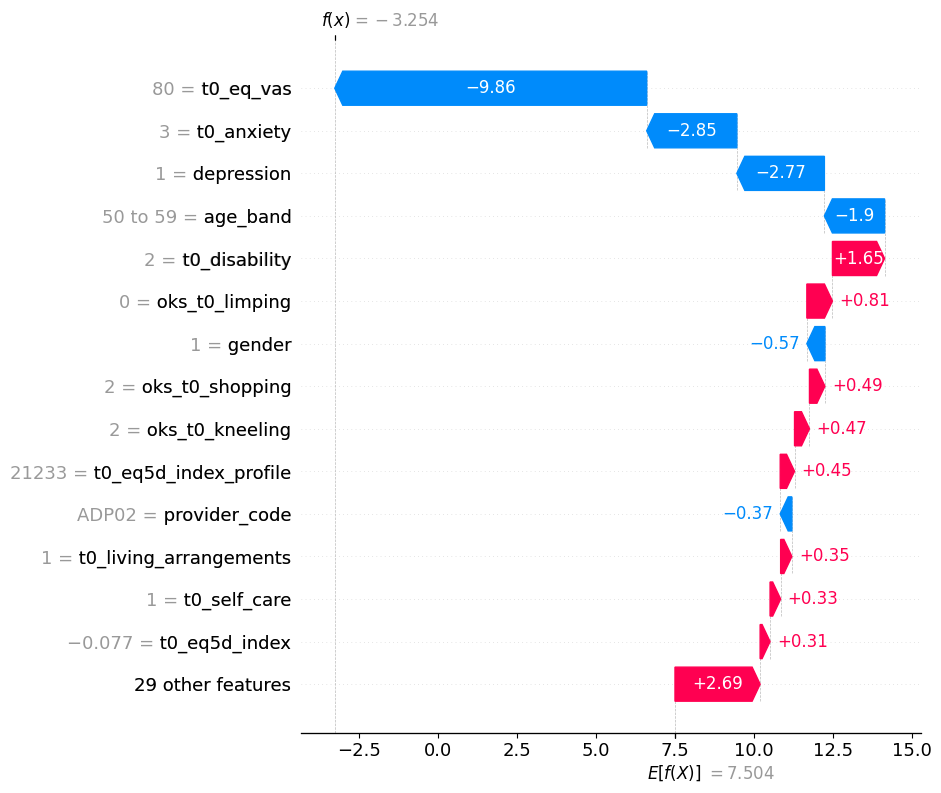

In [18]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=15)

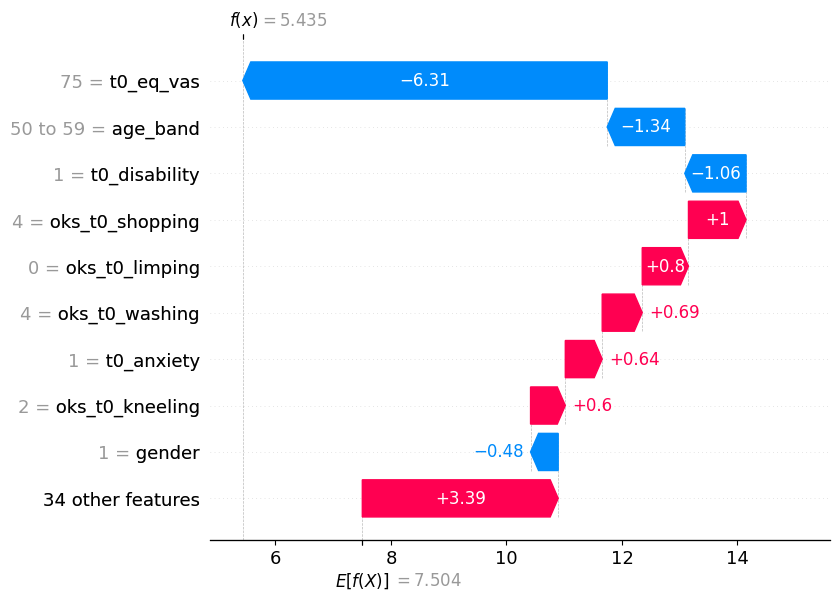

In [19]:
shap.plots.waterfall(shap_values[7])

## Force plots

In [26]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

In [21]:
# visualize all the predictions
shap.plots.force(shap.utils.sample(shap_values, 1000))

## Dependence Plots

In [22]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, ""], color=shap_values)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "Fare"], color=shap_values)

In [ ]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "male"], color=shap_values)

## Beeswarm

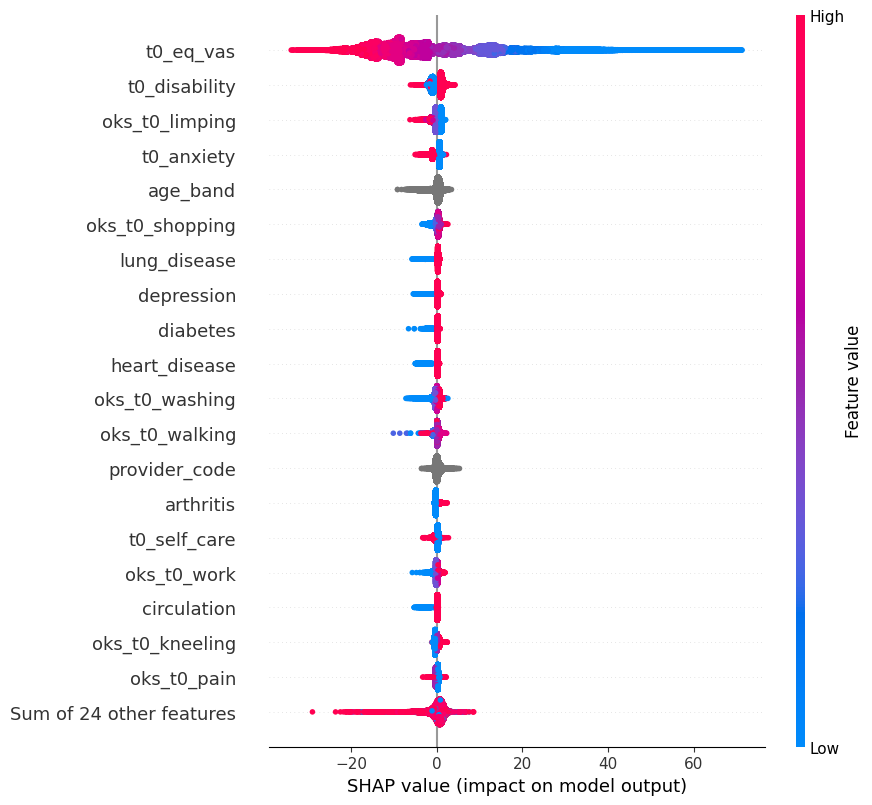

In [28]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=20)

## Bar

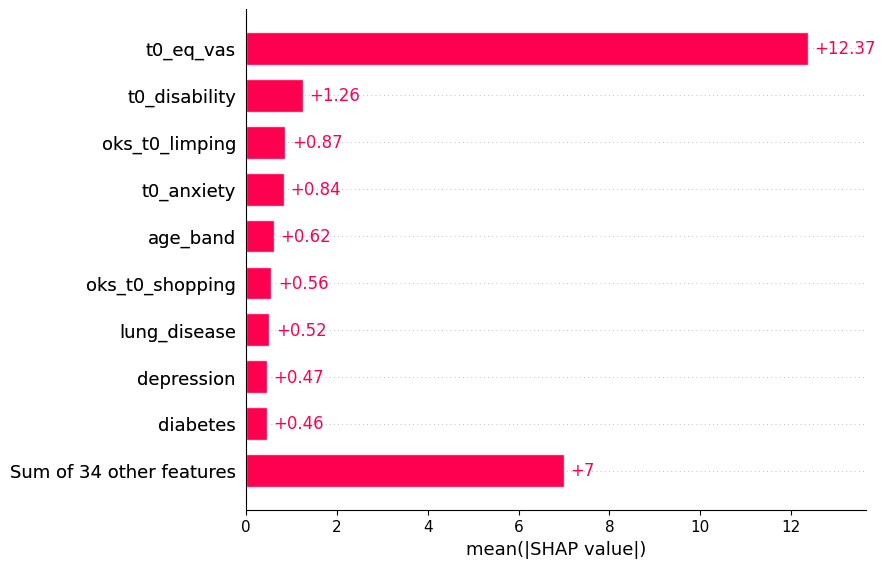

In [29]:
shap.plots.bar(shap_values)

In [33]:
depression = ["Depression" if shap_values[i, "depression"].data == 1 else "No Depression" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(depression).abs.mean(0))

KeyboardInterrupt: 

Plot the bars for an individual.

In [ ]:
shap.plots.bar(shap_values[0])